## Import

In [18]:
import os
from tqdm import tqdm_notebook as tqdm

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import matplotlib.patches as patches
import seaborn as sns
from pylab import rcParams

%matplotlib inline 
plt.style.use('seaborn')
sns.set(style='whitegrid',color_codes=True)

# classifiaction 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import catboost as ctb

# for classification
from sklearn.metrics import accuracy_score

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Hp optimization imports
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import mlflow

import eli5
import gc
import random    
import math
import psutil
import pickle
import datetime
from time import time

# save/load models
from joblib import dump
from joblib import load

In [19]:
root = "../../data/raw/Gamma_Log_Facies_Type_Prediction/"
models_root = "../../models/Gamma_Log_Facies_Type_Prediction/"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('max_columns', 150)
# rcParams['figure.figsize'] = 16,8

## Load data

In [3]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
%%time
train_df = pd.read_csv(root + "Train_File.csv")
test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

reduce_mem_usage(train_df, use_float16=True);
reduce_mem_usage(test_df, use_float16=True);

Memory usage of dataframe is 134.28 MB
Memory usage after optimization is: 29.37 MB
Decreased by 78.1%
Memory usage of dataframe is 67.14 MB
Memory usage after optimization is: 117.77 MB
Decreased by -75.4%
CPU times: user 7.43 s, sys: 727 ms, total: 8.16 s
Wall time: 8.23 s


,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.9375
1,CAX_1,1,5000,120.8750
2,CAX_2,2,5000,115.3125
3,CAX_3,3,5000,118.8750
4,CAX_4,4,5000,127.7500
...,...,...,...,...
2199995,CAX_2199995,1095,6999,145.3750
2199996,CAX_2199996,1096,6999,140.8750
2199997,CAX_2199997,1097,6999,111.2500
2199998,CAX_2199998,1098,6999,148.8750


In [5]:
train_df.head()

,row_id,well_id,GR,label
0,0,0,143.5000,0
1,1,0,112.8125,0
2,2,0,123.5625,0
3,3,0,111.6875,0
4,4,0,123.6250,0


In [6]:
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.9375
1,CAX_1,1,5000,120.8750
2,CAX_2,2,5000,115.3125
3,CAX_3,3,5000,118.8750
4,CAX_4,4,5000,127.7500


In [7]:
submit_df.head()

,unique_id,label
0,CAX_0,NaN
1,CAX_1,NaN
2,CAX_2,NaN
3,CAX_3,NaN
4,CAX_4,NaN


## RandomForestClassifier

In [24]:
rfr = RandomForestClassifier(verbose=0)
rfr.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
param_grid = { 
    'n_estimators': [50],
    'max_depth' : [4, 8, 12],
    'criterion' :['gini', 'entropy']
}

In [32]:
X, y = train_df.drop("label", axis=1), train_df["label"]
skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
model = GridSearchCV(
    estimator=rfr, 
    param_grid=param_grid, 
    n_jobs=-1, cv=skf, 
    scoring="accuracy", 
    verbose=50
)
model.fit(X,y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   4 out of  18 | elapsed:  5.6min remaining: 19.5min
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:  6.0min remaining: 15.6min
[Parallel(n_jobs=-1)]: Done   6 out of  18 | elapsed:  6.0min remaining: 12.0min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:  6.6min remaining: 10.3min
[Parallel(n_jobs=-1)]: Done   8 out of  18 | elapsed:  6.7min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:  7.8min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  8.3min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:  8.7min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  1

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
          

In [33]:
model.best_score_

0.47393772727272726

In [34]:
model.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 50}

In [37]:
%%time

rfc = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500, n_jobs=-1)
rfc.fit(X, y)

CPU times: user 1h 16min 17s, sys: 1min 16s, total: 1h 17min 33s
Wall time: 11min 53s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [38]:
%%time

y_hat = rfc.predict(test_df[["row_id", "well_id", "GR"]])

CPU times: user 1min 51s, sys: 7.82 s, total: 1min 59s
Wall time: 21 s


In [40]:
submit_df["label"] = y_hat
submit_df.to_csv(root+"submission.csv", index=False)
submit_df.head(20)

,unique_id,label
0,CAX_0,0
1,CAX_1,0
2,CAX_2,0
3,CAX_3,0
4,CAX_4,0
5,CAX_5,0
6,CAX_6,0
7,CAX_7,0
8,CAX_8,0
9,CAX_9,0


<BarContainer object of 5 artists>

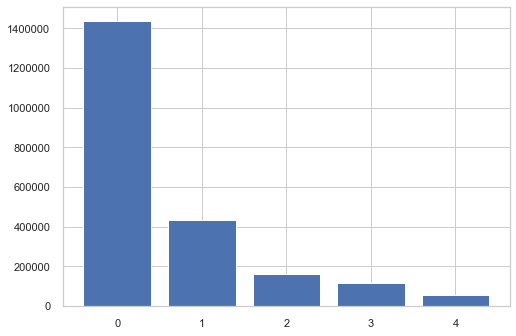

In [42]:
# Количество классов для предсказания

g = submit_df["label"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

In [80]:
mlflow.set_tracking_uri("")

In [79]:

EXPERIMENT_ID = mlflow.create_experiment("gamma_log_facies_type_xgboost_cls_hyperopt")


MlflowException: Experiment 'gamma_log_facies_type_xgboost_cls_hyperopt' already exists.

In [97]:
class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run("", experiment_id=EXPERIMENT_ID):
            print("Training with the following hyperparameters: ")
            print(hyperparameters)
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = xgb.XGBClassifier(**hyperparameters)
            
            loss = cross_val_score(model, X, y, cv=self.skf, scoring="accuracy", n_jobs=-1).mean()
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {'loss': loss, 'status': STATUS_OK}

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best

In [98]:
MAX_EVALS = 150

HYPERPARAMETERS_SPACE = {
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
    'gamma': hp.choice('gamma', np.arange(0.5, 5)),
    'subsample': hp.choice('subsample', [0.6, 0.8, 1.0]),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.6, 1.0)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'n_estimators': 50, 
    'learning_rate': 0.02, 
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

Training with the following hyperparameters:         
{'colsample_bytree': 0.6, 'eta': 0.225, 'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42, 'subsample': 0.8, 'verbosity': 1}
  0%|          | 0/150 [05:13<?, ?it/s, best loss: ?]


KeyboardInterrupt: 

In [83]:
MAX_EVALS = 150

HYPERPARAMETERS_SPACE = {
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
    'gamma': hp.choice('gamma', np.arange(0.5, 5)),
    'subsample': hp.choice('subsample', [0.6, 0.8, 1.0]),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.6, 1.0)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'n_estimators': 50, 
    'learning_rate': 0.02, 
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

2155

In [ ]:
mlflow.set_tracking_uri("")
EXPERIMENT_ID = mlflow.create_experiment("gamma_log_facies_type_xgboost_cls_hyperopt")


In [109]:
mlflow.set_experiment("gamma_log_facies_type_RandomForestClassifier_hyperopt")

class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run(run_name='hyperopt_param'):
            print("Training with the following hyperparameters: ")
            print(hyperparameters)
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = RandomForestClassifier(**hyperparameters)
            
            loss = cross_val_score(model, X, y, cv=self.skf, scoring="accuracy", n_jobs=-1).mean()
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {'loss': -loss, 'status': STATUS_OK}

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best
    
MAX_EVALS = 150

HYPERPARAMETERS_SPACE = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,3)),
    'n_estimators': 20,
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

Training with the following hyperparameters:         
{'criterion': 'entropy', 'max_depth': 19, 'max_features': 2, 'n_estimators': 20}
Training with the following hyperparameters:                                       
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 1, 'n_estimators': 20}    
Training with the following hyperparameters:                                       
{'criterion': 'gini', 'max_depth': 5, 'max_features': 1, 'n_estimators': 20}       
Training with the following hyperparameters:                                       
{'criterion': 'gini', 'max_depth': 4, 'max_features': 1, 'n_estimators': 20}       
Training with the following hyperparameters:                                       
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 2, 'n_estimators': 20}    
Training with the following hyperparameters:                                       
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 1, 'n_estimators': 20}
Training with the following 

KeyboardInterrupt: 

In [112]:
mlflow.set_experiment("gamma_log_facies_type_xgboost_cls_hyperopt_2")

class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run(run_name='hyperopt_param'):
            print("Training with the following hyperparameters: ")
            print(hyperparameters)
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = xgb.XGBClassifier(**hyperparameters)
            
            loss = cross_val_score(model, X, y, cv=self.skf, scoring="accuracy", n_jobs=-1).mean()
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {'loss': -loss, 'status': STATUS_OK}

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best



MAX_EVALS = 150

HYPERPARAMETERS_SPACE = {
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
    'gamma': hp.choice('gamma', np.arange(0.5, 5)),
    'subsample': hp.choice('subsample', [0.6, 0.8, 1.0]),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.6, 1.0)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'max_depth':  hp.choice('max_depth', np.arange(4, 14, dtype=int)),
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'n_estimators': 20, 
    'learning_rate': 0.02, 
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

Training with the following hyperparameters:         
{'colsample_bytree': 0.6, 'eta': 0.47500000000000003, 'gamma': 1.5, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42, 'subsample': 0.6, 'verbosity': 1}
Training with the following hyperparameters:                                      
{'colsample_bytree': 0.6, 'eta': 0.025, 'gamma': 4.5, 'learning_rate': 0.02, 'max_depth': 13, 'min_child_weight': 6, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42, 'subsample': 0.6, 'verbosity': 1}
Training with the following hyperparameters:                                      
{'colsample_bytree': 0.6, 'eta': 0.25, 'gamma': 3.5, 'learning_rate': 0.02, 'max_depth': 13, 'min_child_weight': 9, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42, 'subsample': 1.0, 'verbosity': 1}
Training with the following hyperparameters:                                     
{'colsample_bytree': 0.6, 'eta': 0.325, 'gamma': 1.5, 'learning_rate': 

In [116]:
mlflow.set_experiment("gamma_log_facies_type_xgboost_cls_hyperopt_2")

class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run(run_name='hyperopt_param'):
            print("Training with the following hyperparameters: ")
            print(hyperparameters)
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = xgb.XGBClassifier(**hyperparameters)
            
            loss = cross_val_score(model, X, y, cv=self.skf, scoring="accuracy", n_jobs=-1).mean()
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {'loss': -loss, 'status': STATUS_OK}

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best



MAX_EVALS = 150

HYPERPARAMETERS_SPACE = {
    'min_child_weight': 8,
    'gamma': 3,
    'subsample': 1,
    'colsample_bytree': 0.6,
    'eta': 0.3,
    'max_depth':  4,
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'n_estimators': hp.choice('n_estimators', np.arange(1, 1000, dtype=int)), 
    'learning_rate': 0.02, 
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

Training with the following hyperparameters:         
{'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 3, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 882, 'n_jobs': -1, 'random_state': 42, 'subsample': 1, 'verbosity': 1}
  0%|          | 0/150 [16:55<?, ?it/s, best loss: ?]


KeyboardInterrupt: 

In [117]:
mlflow.set_experiment("gamma_log_facies_type_xgboost_cls_hyperopt_2")

class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run(run_name='hyperopt_param'):
            print("Training with the following hyperparameters: ")
            print(hyperparameters)
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = xgb.XGBClassifier(**hyperparameters)
            
            loss = cross_val_score(model, X, y, cv=self.skf, scoring="accuracy", n_jobs=-1).mean()
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {'loss': -loss, 'status': STATUS_OK}

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best



MAX_EVALS = 150

HYPERPARAMETERS_SPACE = {
    'min_child_weight': 8,
    'gamma': 3,
    'subsample': 1,
    'colsample_bytree': 0.6,
    'eta': 0.3,
    'max_depth':  4,
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'n_estimators': 20, 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.000001), np.log(0.1)), 
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

Training with the following hyperparameters:         
{'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 3, 'learning_rate': 0.0027891246529111475, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42, 'subsample': 1, 'verbosity': 1}
Training with the following hyperparameters:                                      
{'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 3, 'learning_rate': 0.011680282622024111, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42, 'subsample': 1, 'verbosity': 1}
Training with the following hyperparameters:                                      
{'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 3, 'learning_rate': 0.0006893413851240221, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42, 'subsample': 1, 'verbosity': 1}
Training with the following hyperparameters:                                     
{'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 3, 'lea

KeyboardInterrupt: 

In [125]:
X_subset = X[:int(X.shape[0]*0.3)]
y_subset = y[:X_subset.shape[0]]
X_subset.shape, y_subset.shape

((1320000, 3), (1320000,))

In [133]:
mlflow.set_experiment("gamma_log_facies_type_xgboost_cls_hyperopt_subset")

class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run(run_name='hyperopt_param'):
            print("Training with the following hyperparameters: ")
            print(hyperparameters)
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = xgb.XGBClassifier(**hyperparameters)
            X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=RANDOM_STATE, stratify=y_subset)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            loss = accuracy_score(y_test, y_pred)
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {
                'loss': -loss, 
                'status': STATUS_OK,
                'eval_time': time()
            }

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best



MAX_EVALS = 150

HYPERPARAMETERS_SPACE = {
    'min_child_weight': 8,
    'gamma': 3,
    'subsample': 1,
    'colsample_bytree': 0.6,
    'eta': 0.3,
    'max_depth':  4,
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'n_estimators': 20, 
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.9), 
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

Training with the following hyperparameters:         
{'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 3, 'learning_rate': 0.7871441954964349, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42, 'subsample': 1, 'verbosity': 1}
Training with the following hyperparameters:                                     
{'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 3, 'learning_rate': 0.3239432396973265, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42, 'subsample': 1, 'verbosity': 1}
Training with the following hyperparameters:                                     
{'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 3, 'learning_rate': 0.3298180880334005, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42, 'subsample': 1, 'verbosity': 1}
Training with the following hyperparameters:                                     
{'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 3, 'learning_rate

KeyboardInterrupt: 

In [13]:
hyperparameters = {
    'min_child_weight': 8,
    'gamma': 3,
    'subsample': 1,
    'colsample_bytree': 0.6,
    'eta': 0.3,
    'max_depth':  4,
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'n_estimators': 500, 
    'learning_rate': 0.1, 
}

In [14]:
%%time

model = xgb.XGBClassifier(**hyperparameters)
X, y = train_df.drop("label", axis=1), train_df["label"]
model.fit(X, y)


[17:24:34] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 1h 7min 55s, sys: 26.9 s, total: 1h 8min 22s
Wall time: 1h 9min 10s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.3, gamma=3,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=8, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [15]:
%%time

y_hat = model.predict(test_df[["row_id", "well_id", "GR"]])

CPU times: user 2min 42s, sys: 1.07 s, total: 2min 43s
Wall time: 2min 45s


In [16]:
submit_df["label"] = y_hat
submit_df.to_csv(root+"submission.csv", index=False)
submit_df.head(20)

,unique_id,label
0,CAX_0,0
1,CAX_1,0
2,CAX_2,0
3,CAX_3,0
4,CAX_4,0
5,CAX_5,0
6,CAX_6,0
7,CAX_7,0
8,CAX_8,0
9,CAX_9,0


<BarContainer object of 3 artists>

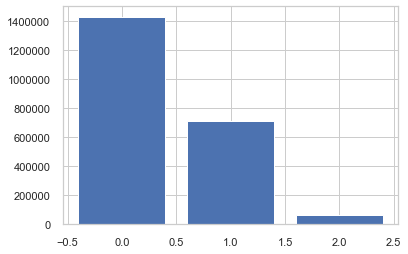

In [17]:
# Количество классов для предсказания

g = submit_df["label"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

In [20]:
model_file = models_root + "gamma_log_facies_type_xgboost_cls_hyperopt_subset.pkl"
dump(model, model_file)
# loaded_model = load(model_file)

['../../models/Gamma_Log_Facies_Type_Prediction/gamma_log_facies_type_xgboost_cls_hyperopt_subset.pkl']